<a href="https://colab.research.google.com/github/vieduy/CS114.K21/blob/master/ML_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd drive/My\ Drive

/content/drive/My Drive


In [2]:
!pip install JSON_minify

## Import các thư viện cần thiết

In [3]:
from sklearn.feature_extraction.image import extract_patches_2d
from script.object_detection import helpers
from script.object_detection.objectdetector import ObjectDetector
from script.descriptors.hog import HOG
from script.utils import dataset
from script.utils.conf import Conf
from imutils import paths
from scipy import io
import numpy as np
import progressbar
import random
from __future__ import print_function
from sklearn.svm import SVC
import pickle
from script.object_detection.nms import non_max_suppression
import cv2
from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow
import imutils

## Đọc file configure chứa các tham số cần thiết và khởi tạo HOG cũng như data và labels

In [4]:
conf = Conf('Conf/sign.json')

# initialize the HOG descriptor along with the list of data and labels
hog = HOG(orientations=conf["orientations"], pixelsPerCell=tuple(conf["pixels_per_cell"]),
          cellsPerBlock=tuple(conf["cells_per_block"]), normalize=conf["normalize"])
data = []
labels = []

## Lấy đường dẫn tất cả những bức ảnh chứa biển báo ở trong thư mục sign(thư mục ảnh training)

In [5]:
# grab the set of ground-truth images and select a percentage of them for training
trnPaths = list(paths.list_images('sign'))
trnPaths = random.sample(trnPaths, int(len(trnPaths) * conf["percent_gt_images"]))
print("[INFO] describing training ROIs...")

[INFO] describing training ROIs...


In [10]:
print(trnPaths[0])
print(len(trnPaths))

sign/4/64.jpg
534


## Preprocessing những bức ảnh trên


1.   Đọc ảnh
2.   Chuyển sang ảnh xám
3.   Resize về 64x64
4.   Trích xuất HOG 
5.   Gán nhãn



In [7]:
# set up the progress bar
widgets = ["Extracting: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(trnPaths), widgets=widgets).start()
# loop over the training paths
for (i, trnPath) in enumerate(trnPaths):
    # load the image, convert it to grayscale, and extract the image ID from the path
    image = cv2.imread(trnPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    id = (trnPath.split('/')[1])
    imageID = trnPath[:].replace(".jpg", "")

    # define the list of ROIs that will be described, based on whether or not the
    # horizontal flip of the image should be used
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)

    # loop over the ROIs
    features = hog.describe(image)
    data.append(features)
    labels.append(int(id))

    # update the progress bar
    pbar.update(i)
pbar.finish()

Extracting: 100% |#############################################| Time:  0:09:52


## Lấy đường dẫn của những bức ảnh "ngoại cảnh" được lưu trong thư mục SceneClass 13

In [9]:
# grab the distraction image paths and reset the progress bar
dstPaths = list(paths.list_images('SceneClass13'))

## Xử lý ảnh ngoại cảnh 
### - Tương tự ảnh trong thư mục Sign. 
### - Sử dụng hàm extract_patches_2d để có thể lấy ngẫu nhiên những bức ảnh size 64x64(max_patches là số ảnh tối đa lấy ra được trong mỗi bức ảnh trong SceneClass13)
### - Gán nhãn là -1  

In [11]:
pbar = progressbar.ProgressBar(maxval=conf["num_distraction_images"], widgets=widgets).start()
print("[INFO] describing distraction ROIs...")

# loop over the desired number of distraction images
for i in np.arange(0, conf["num_distraction_images"]):
    # randomly select a distraction image, load it, convert it to grayscale, and
    # then extract random patches from the image
    image = cv2.imread(random.choice(dstPaths))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    patches = extract_patches_2d(image, (64, 64), max_patches=conf["num_distractions_per_image"])

    # loop over the patches
    for patch in patches:
        # extract features from the patch, then update the data and label list
        features = hog.describe(patch)
        data.append(features)
        labels.append(-1)

    # update the progress bar
    pbar.update(i)

pbar.finish()
print("[INFO] dumping features and labels to file...")

Extracting: N/A% |                                             | ETA:  --:--:--

[INFO] describing distraction ROIs...


Extracting: 100% |#############################################| Time:  0:10:24


[INFO] dumping features and labels to file...


## Khởi tạo model SVM và thực hiện training bằng model.fit

In [12]:
# train the classifier
print("[INFO] training classifier...")
model_svm = SVC(kernel="linear", C=conf["C"], probability=True, random_state=42)
model_svm.fit(data, labels)

[INFO] training classifier...


SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

## Tương tự với KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(data, labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

## Lưu model lại để có thể sử dụng những lần tiếp theo

In [ ]:
# dump the classifier to file
print("[INFO] dumping classifier...")
f = open('output/model_with_hn.cpickle', "wb")
f.write(pickle.dumps(model_svm))
f.close()

[INFO] dumping classifier...


In [ ]:
model = pickle.loads(open(conf["classifier_path"], "rb").read())

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Khởi tạo ObjectDetector

## Xử lý những bức ảnh trong thư mục test tương tự như training

In [14]:
data_test = []
labels_test = []

# grab the set of ground-truth images and select a percentage of them for training
testPaths = list(paths.list_images('test'))
testPaths = random.sample(testPaths, int(len(trnPaths)))
print("[INFO] describing training ROIs...")

[INFO] describing training ROIs...


In [15]:
# set up the progress bar
widgets = ["Extracting: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(trnPaths), widgets=widgets).start()

# loop over the training paths
for (i, testPath) in enumerate(testPaths):
    # load the image, convert it to grayscale, and extract the image ID from the path
    image = cv2.imread(testPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    id = (testPath.split('/')[1])
    imageID = testPath[:].replace(".jpg", "")

    # define the list of ROIs that will be described, based on whether or not the
    # horizontal flip of the image should be used
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)

    # loop over the ROIs
    features = hog.describe(image)
    data_test.append(features)
    labels_test.append(int(id))

    # update the progress bar
    pbar.update(i)

# grab the distraction image paths and reset the progress bar
pbar.finish()

Extracting: 100% |#############################################| Time:  0:03:30


## Dự đoán trên tập test và kết quả

In [64]:
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]
print(labelNames[4])

No entry


### KNN

### SVM

In [17]:
predict = model_svm.predict(data_test)
print(classification_report(labels_test, predict, target_names=labelNames))

                      precision    recall  f1-score   support

       Normal scenes       0.93      1.00      0.96       156
Speed limit (40km/h)       1.00      1.00      1.00        18
         W.207b sign       1.00      0.83      0.91        24
         Pedestrians       1.00      0.70      0.83        27
            No entry       1.00      1.00      1.00        11
          Keep right       1.00      1.00      1.00         8
Roundabout mandatory       1.00      1.00      1.00         6

            accuracy                           0.95       250
           macro avg       0.99      0.93      0.96       250
        weighted avg       0.96      0.95      0.95       250



In [18]:
predict = model_knn.predict(data_test)
print(classification_report(labels_test, predict, target_names=labelNames))

                      precision    recall  f1-score   support

       Normal scenes       0.90      1.00      0.95       156
Speed limit (40km/h)       1.00      0.94      0.97        18
         W.207b sign       1.00      0.38      0.55        24
         Pedestrians       0.73      0.70      0.72        27
            No entry       1.00      1.00      1.00        11
          Keep right       1.00      1.00      1.00         8
Roundabout mandatory       1.00      1.00      1.00         6

            accuracy                           0.90       250
           macro avg       0.95      0.86      0.88       250
        weighted avg       0.91      0.90      0.89       250



## Qua đó ta thấy được rằng SVM cho kết quả tốt hơn KNN vì:


1.   SVM hoạt động tốt với kiểu dữ liệu nhiều chiều. Trong bài này mỗi vector sau khi rút trích HOG đều là vector có số chiều rất lớn
2.   KNN sai nhiều ở hai loại biển báo thứ 2 và thứ 3. Đây là 2 loại biển báo khá tương đồng nhau. Vì vậy KNN khi predict nó sẽ đưa ra kết quả sau khi tính khoảng cách giữa các vector, điều đó dẫn tới việc sẽ có nhiều nhầm lẫn giữa 2 loại biển báo đó nên hiệu suất bị giảm đi đáng kể thay vì training như SVM.




### Test một bức ảnh bất kỳ

In [19]:
od = ObjectDetector(model_svm, hog)

In [73]:
image = cv2.imread('../../test_33.jpg')
(h, w) = image.shape[:2]

### Resize ảnh nhưng vẫn giữ nguyên tỷ lệ (Nếu chiều dài lớn hơn chiều rộng thì resize ảnh theo chiều rộng và ngược lại. Lấy giá trị min giữa 400 và chiều cần xét để tiết kiệm thời gian tìm kiếm mà vẫn đảm bảo tìm ra biển báo trong hình)

In [74]:
if w > h:
    image = imutils.resize(image, height=min(256, image.shape[0]))
else:
    image = imutils.resize(image, width=min(256, image.shape[1]))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(h, w) = gray.shape[:2]
print(h, w)

256 341


### Detect biển báo. Kết quả trả về có thể 1 hoặc nhiều vị trí có thể thỏa mãn chứa biển báo. Áp dụng kỹ thuật NMS để tìm ra vị trí tối ưu nhất

In [51]:
# detect objects in the image and apply non-maxima suppression to the bounding boxes
(boxes, probs, labels) = od.detect(gray, (64, 64), winStep=8,
                           pyramidScale=1.45, minProb=conf["min_probability"])
(pick, labels) = non_max_suppression(np.array(boxes), probs, conf["overlap_thresh"], labels)
orig = image.copy()

5
0.006485114067009193
(176, 235)
4
0.031001385525625858
4
0.013323202134195562
5
0.005784957475764651
(121, 162)
(82, 111)
(56, 76)


## Show kết quả sau khi detect biển báo

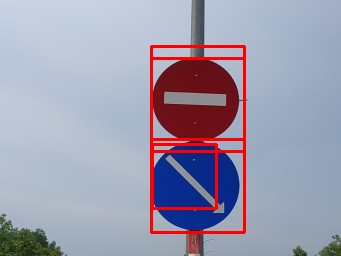

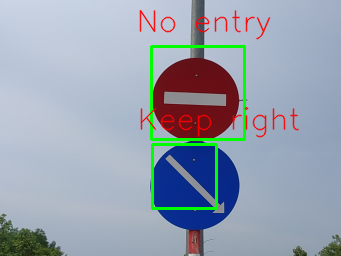

-1

In [75]:
# loop over the original bounding boxes and draw them
for (startX, startY, endX, endY) in boxes:
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 0, 255), 2)

# loop over the allowed bounding boxes and draw them
for (i, (startX, startY, endX, endY)) in enumerate(pick):
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    cv2.putText(image, labelNames[int(labels[i])],  (startX - 15, startY - 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)

# show the output images
cv2_imshow(orig)
cv2_imshow(image)
cv2.waitKey(0)